# XGBOOST
## Обучение дерева на синтезированных данных -> проверка на реальных 
## Это будет являться критерием, по которому можно оценить соответствие синтезированных данных реальным. 
## (Задача бинарной классификации)
###  Обучение и проверка дерева на реальных данных дает дает разделение с roc_auc = 0.64, accuracy = 0.64. Возьмем эти значения за эталон.

In [1]:
import pandas as pd
import uproot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics

In [2]:
data = pd.read_csv('example.csv')


data.drop(data.columns[[0]], axis  =1, inplace = True)

data = data.reset_index()
data.drop(data.columns[[0]], axis  =1, inplace = True)

In [3]:
data

,TimeAtHeightX1,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,...,derivative40,derivative41,derivative42,derivative43,derivative44,derivative45,derivative46,derivative47,derivative48,label
0,0,0.044361,0.095117,0.158157,0.213047,0.257228,0.296225,0.325614,0.346224,0.363044,...,3.052496,2.948297,2.712170,2.439880,2.268714,2.040135,1.662041,1.323110,0.845058,1
1,0,0.008589,0.014430,0.018910,0.022891,0.026594,0.030119,0.033327,0.036419,0.039544,...,3.082330,2.710328,2.283024,1.732488,1.506395,1.236028,0.805763,0.359455,0.260226,1
2,0,0.041737,0.073801,0.103252,0.133073,0.162863,0.190822,0.218377,0.245883,0.271225,...,2.243307,2.144865,1.960321,1.797387,1.512727,1.254023,0.968580,0.702520,0.455818,1
3,0,0.036833,0.059463,0.077316,0.093439,0.107795,0.121003,0.133391,0.145389,0.157362,...,1.163360,1.039595,0.928542,0.845879,0.688672,0.559020,0.484084,0.401463,0.288967,1
4,0,0.044630,0.072822,0.097708,0.121547,0.146484,0.174410,0.204121,0.236338,0.267417,...,1.969109,1.822022,1.582219,1.359921,1.206870,0.890646,0.585812,0.350209,0.344486,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111235,0,0.035990,0.058350,0.077057,0.094282,0.111318,0.127929,0.144589,0.161491,0.179448,...,1.665404,1.538333,1.444352,1.314600,1.227529,1.073831,0.935907,0.698844,0.356494,0
111236,0,0.036452,0.059447,0.077652,0.094275,0.110435,0.126432,0.142379,0.157990,0.173635,...,1.062692,0.933718,0.827422,0.738681,0.643670,0.559041,0.497756,0.475284,0.439610,0
111237,0,0.045551,0.075094,0.099289,0.120287,0.139726,0.157824,0.175347,0.191973,0.208276,...,0.780026,0.734883,0.696725,0.715136,0.731703,0.715519,0.677008,0.628817,0.448906,0
111238,0,0.017389,0.033395,0.048352,0.064819,0.082793,0.103359,0.125756,0.144527,0.162204,...,1.139093,1.073319,1.094798,1.112963,1.123584,1.040938,0.801556,0.524891,0.527781,0


In [4]:
data.drop('TimeAtHeightX1', axis = 1, inplace = True)
data.drop('TimeAtHeightX50', axis = 1, inplace = True)


for i in range(1, 49):                                       # удаление всех лишних параметров
    data.drop('derivative'+str(i), axis = 1, inplace = True)

In [5]:
data

,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,TimeAtHeightX11,...,TimeAtHeightX41,TimeAtHeightX42,TimeAtHeightX43,TimeAtHeightX44,TimeAtHeightX45,TimeAtHeightX46,TimeAtHeightX47,TimeAtHeightX48,TimeAtHeightX49,label
0,0.044361,0.095117,0.158157,0.213047,0.257228,0.296225,0.325614,0.346224,0.363044,0.378235,...,0.658348,0.665132,0.672506,0.680703,0.689518,0.699322,0.711355,0.726471,0.750138,1
1,0.008589,0.014430,0.018910,0.022891,0.026594,0.030119,0.033327,0.036419,0.039544,0.042679,...,0.163943,0.171323,0.180083,0.191627,0.204904,0.221085,0.245906,0.301545,0.378402,1
2,0.041737,0.073801,0.103252,0.133073,0.162863,0.190822,0.218377,0.245883,0.271225,0.294935,...,0.715044,0.724368,0.734571,0.745698,0.758919,0.774868,0.795516,0.823985,0.867863,1
3,0.036833,0.059463,0.077316,0.093439,0.107795,0.121003,0.133391,0.145389,0.157362,0.168961,...,0.506903,0.526141,0.547680,0.571324,0.600366,0.636143,0.677458,0.727276,0.796488,1
4,0.044630,0.072822,0.097708,0.121547,0.146484,0.174410,0.204121,0.236338,0.267417,0.296698,...,0.726086,0.737063,0.749703,0.764410,0.780982,0.803437,0.837578,0.894687,0.952744,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111235,0.035990,0.058350,0.077057,0.094282,0.111318,0.127929,0.144589,0.161491,0.179448,0.198949,...,0.554418,0.567419,0.581266,0.596480,0.612773,0.631398,0.652767,0.681386,0.737488,0
111236,0.036452,0.059447,0.077652,0.094275,0.110435,0.126432,0.142379,0.157990,0.173635,0.188613,...,0.591379,0.612798,0.636970,0.664045,0.695117,0.730892,0.771073,0.813153,0.858648,0
111237,0.045551,0.075094,0.099289,0.120287,0.139726,0.157824,0.175347,0.191973,0.208276,0.224162,...,0.677829,0.705044,0.733750,0.761717,0.789050,0.817002,0.846544,0.878350,0.922902,0
111238,0.017389,0.033395,0.048352,0.064819,0.082793,0.103359,0.125756,0.144527,0.162204,0.178808,...,0.693225,0.711859,0.730127,0.748097,0.765897,0.785111,0.810062,0.848165,0.886060,0


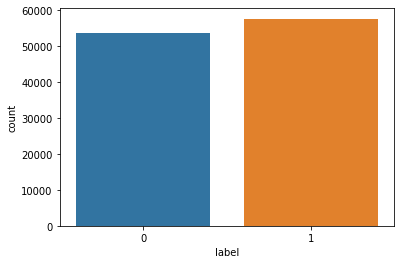

In [6]:
sns.countplot(x = 'label', data=data)

## Обучение

In [7]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data.iloc[:,0:-1],data.iloc[:,-1],test_size=0.3, random_state=1)

In [8]:
train_X

,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,TimeAtHeightX11,...,TimeAtHeightX40,TimeAtHeightX41,TimeAtHeightX42,TimeAtHeightX43,TimeAtHeightX44,TimeAtHeightX45,TimeAtHeightX46,TimeAtHeightX47,TimeAtHeightX48,TimeAtHeightX49
109442,0.038760,0.068784,0.094984,0.118894,0.140044,0.159724,0.177812,0.194637,0.210858,0.226914,...,0.648953,0.661412,0.674978,0.689946,0.705783,0.723383,0.744211,0.769747,0.802145,0.845895
36340,0.047698,0.085489,0.115120,0.140637,0.168711,0.199423,0.235036,0.272016,0.304543,0.330440,...,0.720798,0.728850,0.737085,0.745671,0.754691,0.764373,0.775401,0.788695,0.807191,0.833383
19745,0.064493,0.096726,0.120811,0.143158,0.163993,0.182479,0.198905,0.214771,0.230056,0.243614,...,0.591284,0.615829,0.643832,0.675351,0.712032,0.753799,0.801406,0.854530,0.910178,0.960969
40157,0.038609,0.062332,0.082215,0.101501,0.118460,0.133487,0.147939,0.162164,0.175971,0.189455,...,0.634426,0.646769,0.659596,0.672890,0.686045,0.699785,0.714897,0.733329,0.758758,0.801200
40822,0.035355,0.063027,0.088982,0.114810,0.141225,0.166647,0.191279,0.214907,0.237925,0.261082,...,0.679235,0.694129,0.710871,0.730546,0.751375,0.773081,0.798686,0.828477,0.870492,0.918469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,0.047949,0.086368,0.123564,0.159815,0.192728,0.219785,0.244906,0.269563,0.293137,0.316644,...,0.709929,0.718354,0.727195,0.736895,0.747462,0.759783,0.774466,0.793190,0.819502,0.857206
98047,0.054626,0.079871,0.099248,0.116138,0.131537,0.145489,0.159215,0.172188,0.184877,0.196967,...,0.618211,0.648561,0.683684,0.716537,0.746065,0.772168,0.799251,0.834540,0.885246,0.951169
5192,0.038592,0.066646,0.091028,0.113915,0.135734,0.155867,0.175499,0.194886,0.214213,0.233642,...,0.687029,0.697759,0.709065,0.721400,0.735223,0.751083,0.769994,0.793293,0.826177,0.882713
77708,0.034128,0.070157,0.111902,0.157289,0.197161,0.231793,0.265446,0.298901,0.330605,0.359392,...,0.780902,0.789513,0.798626,0.808747,0.820073,0.834061,0.852373,0.883568,0.937741,0.998141


In [9]:
xgbc = XGBClassifier()
print(xgbc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [10]:
xgbc.fit(train_X, train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
test_X

,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,TimeAtHeightX11,...,TimeAtHeightX40,TimeAtHeightX41,TimeAtHeightX42,TimeAtHeightX43,TimeAtHeightX44,TimeAtHeightX45,TimeAtHeightX46,TimeAtHeightX47,TimeAtHeightX48,TimeAtHeightX49
308,0.028458,0.056271,0.087419,0.116040,0.137913,0.155001,0.170220,0.183048,0.194640,0.205961,...,0.441855,0.447710,0.454083,0.461367,0.469544,0.479518,0.492247,0.509787,0.534816,0.632643
18875,0.029584,0.054646,0.076789,0.098500,0.120879,0.143324,0.166229,0.191146,0.213422,0.236255,...,0.658069,0.666554,0.675469,0.685043,0.695642,0.707479,0.721492,0.739934,0.768059,0.896900
85127,0.068441,0.114896,0.151614,0.186667,0.220503,0.255120,0.294285,0.334547,0.382059,0.433718,...,0.820373,0.827605,0.835528,0.844217,0.853649,0.864457,0.876832,0.891071,0.906951,0.928236
106910,0.039769,0.064389,0.084694,0.103164,0.120732,0.137722,0.154627,0.172056,0.190367,0.210230,...,0.594607,0.604169,0.614091,0.624377,0.635182,0.646380,0.658832,0.673554,0.693977,0.727179
92046,0.046524,0.082522,0.110938,0.135658,0.158801,0.180160,0.199185,0.216309,0.232349,0.247600,...,0.614385,0.631443,0.649954,0.671158,0.695976,0.725231,0.758930,0.790816,0.825380,0.893081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44806,0.030361,0.055095,0.079050,0.105292,0.132813,0.157359,0.180736,0.204496,0.226715,0.249022,...,0.683951,0.692851,0.702104,0.712200,0.722924,0.734927,0.749135,0.768080,0.797234,0.861749
104586,0.022676,0.040048,0.056110,0.073134,0.090270,0.108289,0.127004,0.145342,0.166877,0.193063,...,0.614597,0.625844,0.637816,0.650715,0.665258,0.681886,0.702370,0.727771,0.755143,0.801342
81467,0.039081,0.087695,0.139071,0.202238,0.259242,0.302875,0.337837,0.366236,0.392432,0.416136,...,0.809800,0.819456,0.829969,0.841175,0.853595,0.867466,0.883234,0.902062,0.925781,0.964253
64027,0.052802,0.098152,0.136931,0.174889,0.211248,0.246918,0.280497,0.309339,0.335530,0.360070,...,0.813113,0.822417,0.832407,0.843754,0.856599,0.871497,0.888083,0.907408,0.934468,0.996996


## Тест на синтезированных данных (другой выборке)

In [14]:
ypred = xgbc.predict_proba(test_X)

In [15]:
ypred

array([[0.3046254 , 0.6953746 ],
       [0.24426222, 0.7557378 ],
       [0.45515656, 0.54484344],
       ...,
       [0.39822233, 0.6017777 ],
       [0.37352943, 0.62647057],
       [0.6163864 , 0.38361356]], dtype=float32)

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(test_Y, ypred[:, 1])

In [21]:
thrs =0.5

In [23]:
ypred2 = (ypred[:, 1]>=thrs)

In [24]:
print ('accuracy = ' + str(metrics.accuracy_score(test_Y, ypred2)))

accuracy = 0.7373247033441208


roc_auc = 0.7366800598664518


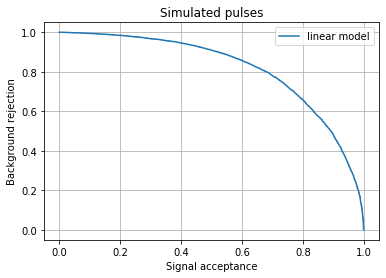

In [25]:
plt.plot( tpr,  np.abs(1-fpr), label = 'linear model')
plt.xlabel('Signal acceptance')
plt.ylabel('Background rejection')
plt.title('Simulated pulses')
plt.grid()
plt.legend()
print('roc_auc = '+ str(metrics.roc_auc_score(test_Y, ypred2)))

C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Simulated pulses')

<Figure size 2880x2160 with 0 Axes>

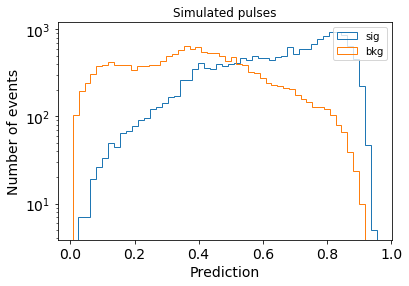

In [26]:
A = np.array(ypred[:,1])
idx_sig = np.where(test_Y == 1)[0] #signal
idx_bkg = np.where(test_Y == 0)[0]# выдает номера 


# Histogram predictions without error bars: #количес
bins = 50
fig14 = plt.figure(figsize=(40,30))
fig14, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(A[[idx_sig]], histtype='step', label='sig', bins = bins)
n2, bins2, patches2 = ax.hist(A[[idx_bkg]], histtype='step', label='bkg', bins = bins)
ax.set_xlabel('Prediction', {'fontsize': 14})
ax.set_ylabel('Number of events', {'fontsize': 14})
plt.yticks((10**0, 10**1, 10**2, 10**3), color='k', size=14)
plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
plt.yscale('log')
plt.legend(loc="upper right")
#fig14.savefig("predictions.pdf", bbox_inches='tight')
plt.title('Simulated pulses')

In [27]:
print ('f1= ' +str(metrics.f1_score(test_Y, ypred2)))

f1= 0.7488683893886438


In [28]:
sklearn.metrics.confusion_matrix(test_Y, ypred2)

array([[11536,  4464],
       [ 4302, 13070]], dtype=int64)

In [29]:
# tn, fp, 
# fn, tp

## Тест на реальных данных 

In [30]:
test_X = pd.read_csv('/Users/zaret/Desktop/gerda/ANG5_cal.csv')  # загрузка реальных данных и удаление лишних столбцов
test_X.drop(test_X.columns[[0]], axis  =1, inplace = True)
test_Y = test_X['label']
test_X = test_X.drop('label', axis  =1)

test_X = test_X.drop('integral', axis = 1)

for i in range (1,49):
    test_X.drop('integral'+str(i), axis = 1, inplace = True)
    
test_X.drop('derivative49', axis = 1, inplace = True)


for i in range(1, 49):
    test_X.drop('derivative'+str(i), axis = 1, inplace = True)

In [31]:
ypred = xgbc.predict_proba(test_X)

In [32]:
ypred

array([[0.95578486, 0.04421514],
       [0.6946023 , 0.3053977 ],
       [0.34864467, 0.6513553 ],
       ...,
       [0.17647594, 0.82352406],
       [0.29298627, 0.7070137 ],
       [0.8441445 , 0.15585549]], dtype=float32)

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(test_Y, ypred[:, 1])

In [38]:
thrs = 0.5

In [40]:
ypred2 = (ypred[:, 1]>=thrs)

In [41]:
print ('accuracy = ' + str(metrics.accuracy_score(test_Y, ypred2)))

accuracy = 0.651760986250337


roc_auc = 0.651760986250337


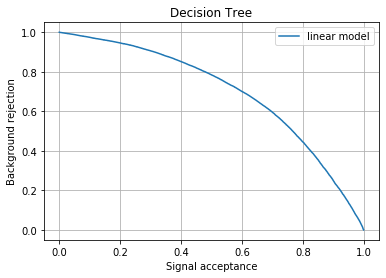

In [42]:
plt.plot( tpr,  np.abs(1-fpr), label = 'linear model')
plt.xlabel('Signal acceptance')
plt.ylabel('Background rejection')
plt.title('Decision Tree')
plt.grid()
plt.legend()
print('roc_auc = '+ str(metrics.roc_auc_score(test_Y, ypred2)))

C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Decision Tree')

<Figure size 2880x2160 with 0 Axes>

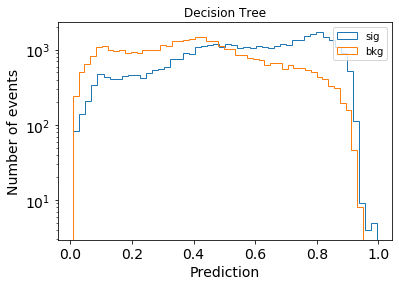

In [43]:
A = np.array(ypred[:,1])
idx_sig = np.where(test_Y == 1)[0] #signal
idx_bkg = np.where(test_Y == 0)[0]# выдает номера 


# Histogram predictions without error bars: #количес
bins = 50
fig14 = plt.figure(figsize=(40,30))
fig14, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(A[[idx_sig]], histtype='step', label='sig', bins = bins)
n2, bins2, patches2 = ax.hist(A[[idx_bkg]], histtype='step', label='bkg', bins = bins)
ax.set_xlabel('Prediction', {'fontsize': 14})
ax.set_ylabel('Number of events', {'fontsize': 14})
plt.yticks((10**0, 10**1, 10**2, 10**3), color='k', size=14)
plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
plt.yscale('log')
plt.legend(loc="upper right")
#fig14.savefig("predictions.pdf", bbox_inches='tight')
plt.title('Decision Tree')

In [44]:
print ('f1= ' +str(metrics.f1_score(test_Y, ypred2)))

f1= 0.6424320209379286


In [45]:
sklearn.metrics.confusion_matrix(test_Y, ypred2)

array([[27657, 13144],
       [15273, 25528]], dtype=int64)

In [46]:
# tn, fp, 
# fn, tp

## Вывод: по этому критерию синтезированные данные соответствуют реальным  